In [2]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update



In [3]:
%load_ext google.cloud.bigquery

In [4]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from scipy.stats import pearsonr, ttest_1samp, ttest_ind

2023-08-31 18:54:57.971139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
sys.path.insert(0, '../utils')

from utils import min_max_standardize

First batch of features to look at
+ {click, purchase}Level2TaxonomyPaths
+ {click, purchase}Level2TaxonomyCounts
+ {click, purchase}Level2TaxonomyPrices

# Training data

```sql
create or replace table `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_07_03`
as (
    with fl as (
        select
            requestUUID, visitId, position, 
            candidateInfo.docInfo.listingInfo.listingId, 
            candidateInfo.scores,
            candidateInfo.docInfo.listingInfo.activeListingBasics.priceUsd,
            candidateInfo.docInfo.listingInfo.verticaListings.shopId,
            candidateInfo.docInfo.listingInfo.verticaListings.taxonomyPath,
            candidateInfo.docInfo.listingInfo.verticaListings.tags,
            attributions,
            ctx.docInfo.queryInfo.query, 
            ctx.docInfo.queryInfo.queryTaxoDemandFeatures.*,
            
         from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_07_03`, unnest(contextualInfo) as ctx
         where ctx.docInfo.queryInfo.query is not null
         order by requestUUID, position
    ),
    query_gms as (
      select query, sum(attributed_gms) as gms
      from `etsy-data-warehouse-prod.search.query_sessions_new`
      where _date = date('2023-07-03')
      group by query
    )
    select fl.*, gms
    from fl
    left join query_gms
    on fl.query = query_gms.query
)
```

```sql
with query_with_taxoes as (
  select *
  from `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_07_03`
  where array_length(purchaseLevel2TaxonomyPaths) > 0
),
query_gms as (
  select distinct query, gms
  from query_with_taxoes
)
select sum(gms) from query_gms
```

queries with purchased taxonomies on one of the days in training data

07/03  (90 day look back)
+ total: 827734 queries, 99038566 GMS
+ have purchase taxos: 290207 queries (35.1%), 62946653 GMS (63.6%)
+ have more than 1 purchased taxoes: 75488 queries (9.1%), 30887075 GMS (31.2%)
+ have click taxos: 535593 queries (64.7%), 81547957 GMS (82.3%)
+ have more than 1 clicked taxoes: 301673 queries (36.4%), 59444566 GMS (60.0%)

07/16  (120 day look back)
+ total: 826779 queries, 93662392 GMS
+ have purchase taxos: 294935 queries (35.7%), 60425515 GMS (64.5%)
+ have more than 1 purchased taxoes: 87489 queries (10.6%), 32382506 GMS (34.6%)
+ have click taxoes: 542367 queries (65.6%), 77603049 GMS (82.9%)
+ have more than 1 clicked taxoes: 307312 queries (37.2%), 56676797 GMS (60.5%)

In [15]:
%%bigquery df
select query, query_bin, attributions, purchaseLevel2TaxonomyPaths, purchaseLevel2TaxonomyCounts
from `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_08_15`
where array_length(purchaseLevel2TaxonomyPaths) > 0

Downloading: 100%|████████████| 51158940/51158940 [02:08<00:00, 399468.70rows/s]


In [16]:
df.head()

,query,query_bin,attributions,purchaseLevel2TaxonomyPaths,purchaseLevel2TaxonomyCounts
0,iron on label,None,[no_event],"[paper_and_party_supplies.paper, craft_supplie...","[134, 15, 8, 4, 4, 2, 1, 1, 1]"
1,doctor who,None,[no_event],"[accessories.patches_and_pins, home_and_living...","[17, 16, 10, 7, 7, 5, 4, 4, 4, 4, 3, 3, 2, 2, ..."
2,my aunt is cooler than my dad,None,[no_event],"[clothing.gender_neutral_kids_clothing, clothi...","[11, 4]"
3,love reading in one hour,None,[no_event],"[home_and_living.spirituality_and_religion, ar...","[110, 5]"
4,back to school svg,None,[no_event],"[craft_supplies_and_tools.canvas_and_surfaces,...","[134, 29, 22, 20, 10, 3]"


In [15]:
df.purchaseLevel2TaxonomyPaths[0]

array(['craft_supplies_and_tools.canvas_and_surfaces',
       'art_and_collectibles.drawing_and_illustration',
       'art_and_collectibles.prints',
       'craft_supplies_and_tools.patterns_and_how_to',
       'paper_and_party_supplies.paper',
       'craft_supplies_and_tools.knives_and_cutting_tools',
       'clothing.gender_neutral_adult_clothing',
       'paper_and_party_supplies.party_supplies', ''], dtype=object)

In [13]:
df.purchaseLevel2TaxonomyCounts[0]

array([588, 367, 239, 178,   2,   1,   1,   1,   1])

In [17]:
print(len(df.purchaseLevel2TaxonomyPaths[0]))
print(len(df.purchaseLevel2TaxonomyCounts[0]))
print(df.purchaseLevel2TaxonomyPaths[0][-1])

9
9



Attributions

```sql
with tmp as ( 
    select attr_strs
    from `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_07_03`, unnest(attributions) as attr_strs
)
select attr_strs, count(*) as cnt
from tmp
group by attr_strs
```

In [8]:
tmp = list(df.attributions.values)
labels = [item for sublist in tmp for item in sublist]

In [10]:
len(labels)

21407343

In [11]:
Counter(labels)

Counter({'no_event': 20696937,
         'click': 615718,
         'fav': 6399,
         'cart_add': 62463,
         'purchase': 25826})

Distribution of number of taxonomies per query

In [17]:
df['feature_length'] = df.purchaseLevel2TaxonomyPaths.apply(lambda x: len(x))

In [23]:
df.shape

(46160549, 6)

In [19]:
df.columns

Index(['query', 'query_bin', 'attributions', 'purchaseLevel2TaxonomyPaths',
       'purchaseLevel2TaxonomyCounts', 'feature_length'],
      dtype='object')

In [22]:
df = df[~df.query_bin.isna()]

<Axes: xlabel='query_bin', ylabel='feature_length'>

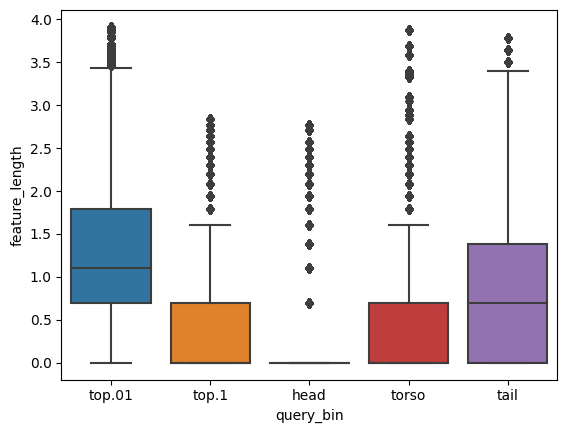

In [27]:
sns.boxplot(x = df.query_bin, y=np.log(df.feature_length), order=["top.01", "top.1", "head", "torso", "tail"])

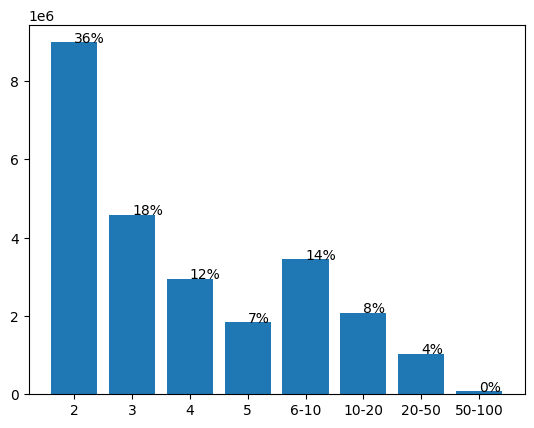

In [9]:
bins = [2, 3, 4, 5, 6, 10, 20, 50, 100]
bin_labels = ["2", "3", "4", "5", "6-10", "10-20", "20-50", "50-100"]

hist_values = np.histogram(df.feature_length, bins = bins)[0]
percentage = ["{0:.0%}".format(x) for x in np.round(hist_values / df.shape[0], 5)]

ax = plt.bar(x=bin_labels, height=hist_values)
for x, y, p in zip(bin_labels, hist_values, percentage):
    plt.text(x, y, p)

plt.show()

In [10]:
hist_values

array([8987997, 4585246, 2951371, 1834099, 3447235, 2075896, 1035853,
         74762])

In [4]:
%%bigquery df
select query, clickLevel2TaxonomyPaths, clickLevel2TaxonomyCounts
from `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_07_03`
where array_length(clickLevel2TaxonomyPaths) > 1

Downloading: 100%|█████████████████████████████████████████████████████████████████| 46708584/46708584 [04:18<00:00, 180745.10rows/s]


In [5]:
df.head()

,query,clickLevel2TaxonomyPaths,clickLevel2TaxonomyCounts
0,nirvana sweatshirt,"[clothing.gender_neutral_adult_clothing, weddi...","[1938, 267, 144, 103, 15, 10, 4, 3, 2, 2, 1, 1..."
1,beer shirt,"[clothing.gender_neutral_adult_clothing, cloth...","[868, 128, 87, 34, 8, 5, 4, 3]"
2,dxf,"[craft_supplies_and_tools.patterns_and_how_to,...","[879, 433, 144, 118, 98, 75, 70, 28, 8, 7, 7, ..."
3,invitation wedding,"[weddings.invitations_and_paper, paper_and_par...","[932, 95, 12, 4, 2, 1, 1]"
4,baptism,"[home_and_living.home_decor, paper_and_party_s...","[240, 231, 208, 200, 147, 140, 99, 51, 45, 41,..."


In [6]:
df['feature_length'] = df.clickLevel2TaxonomyPaths.apply(lambda x: len(x))

In [14]:
df.feature_length.max()

50

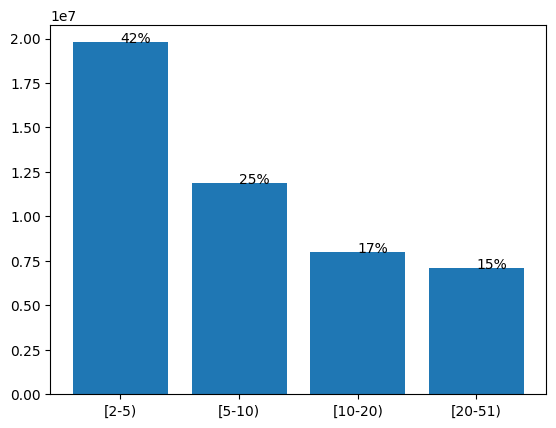

In [17]:
bins = [2, 5, 10, 20, 51]
bin_labels = ["[2-5)", "[5-10)", "[10-20)", "[20-51)"]

hist_values = np.histogram(df.feature_length, bins = bins)[0]
percentage = ["{0:.0%}".format(x) for x in np.round(hist_values / df.shape[0], 5)]

ax = plt.bar(x=bin_labels, height=hist_values)
for x, y, p in zip(bin_labels, hist_values, percentage):
    plt.text(x, y, p)

plt.show()

# Counts vs Price 

In [4]:
%%bigquery df
select 
    query, 
    purchaseLevel2TaxonomyPaths as taxo, 
    purchaseLevel2TaxonomyCounts as cnts,
    purchaseLevel2TaxonomyPrices  as prices,
from `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_07_03`
where array_length(purchaseLevel2TaxonomyPaths) > 1

Downloading: 100%|████████████| 21314469/21314469 [01:16<00:00, 277739.14rows/s]


In [5]:
df.head()

,query,taxo,cnts,prices
0,picture frames,"[home_and_living.home_decor, weddings.gifts_an...","[219, 35, 5, 2]","[18.21, 17.69, 16.76, 8.07]"
1,wedding welcome sign,"[weddings.decorations, weddings.invitations_an...","[286, 166, 16, 13, 8, 3, 2, 1, 1, 1]","[42.54, 11.9, 13.19, 63.75, 42.18, 16.87, 2.08..."
2,30th birthday gift for her,"[paper_and_party_supplies.paper, clothing.gend...","[168, 112, 101, 88, 62, 61, 54, 47, 33, 27, 19...","[4.64, 20.7, 14.22, 16.56, 35.32, 21.25, 35.77..."
3,tshirt,"[clothing.gender_neutral_adult_clothing, , clo...","[138, 52, 23, 14, 10, 4, 2, 2, 2, 2, 2]","[19.74, 16.74, 17.04, 19.73, 10.32, 8.03, 30.0..."
4,croc charm,"[jewelry.brooches_pins_and_clips, craft_suppli...","[462, 329, 126, 39, 17]","[4.6, 2.52, 9.31, 3.44, 3.22]"


In [7]:
df_sub = df[110000:120000].reset_index(inplace=False)

In [8]:
std_counts = df_sub.cnts.apply(min_max_standardize)
std_prices = df_sub.prices.apply(min_max_standardize)

In [9]:
corr_seq = []
for i in range(df_sub.shape[0]):
    curr_cnts = std_counts[i]
    curr_prices = std_prices[i]
    if len(curr_cnts) > 2:
        try:
            curr_corr, _ = pearsonr(curr_cnts, curr_prices)
            corr_seq.append(curr_corr)
        except:
            print(curr_cnts)

[nan nan nan nan nan nan nan nan]
[nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan]


(array([ 243.,  181.,  386.,  764., 1609., 1362.,  877.,  701.,  665.,
         776.]),
 array([-9.99996610e-01, -7.99996949e-01, -5.99997288e-01, -3.99997627e-01,
        -1.99997966e-01,  1.69503361e-06,  2.00001356e-01,  4.00001017e-01,
         6.00000678e-01,  8.00000339e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

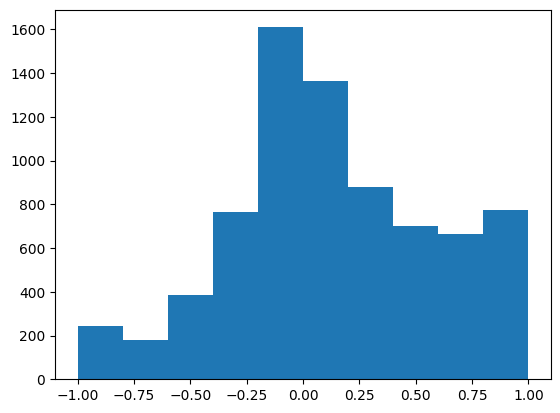

In [10]:
plt.hist(corr_seq)

In [11]:
print(len(corr_seq))
print(np.mean(corr_seq))
print(np.median(corr_seq))

7564
0.1336769848501378
0.08317793250804395


In [12]:
ttest_1samp(corr_seq, popmean=0.)

TtestResult(statistic=25.20590130594515, pvalue=1.1089738037777045e-134, df=7563)

How about clicks

In [6]:
%%bigquery clicks_df
select
    query, 
    clickLevel2TaxonomyPaths as taxo, 
    clickLevel2TaxonomyCounts as cnts,
    clickLevel2TaxonomyPrices  as prices,
from `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_07_03`
where array_length(clickLevel2TaxonomyPaths) > 1

Downloading: 100%|████████████| 46708584/46708584 [05:00<00:00, 155424.83rows/s]


In [12]:
df_sub = clicks_df[90000:100000].reset_index(inplace=False)
std_counts = df_sub.cnts.apply(min_max_standardize)
std_prices = df_sub.prices.apply(min_max_standardize)

In [13]:
corr_seq = []
for i in range(df_sub.shape[0]):
    curr_cnts = std_counts[i]
    curr_prices = std_prices[i]
    if len(curr_cnts) > 2:
        try:
            curr_corr, _ = pearsonr(curr_cnts, curr_prices)
            corr_seq.append(curr_corr)
        except:
            print(curr_cnts)

[nan nan nan]
[nan nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]


(array([ 158.,  142.,  338.,  816., 3219., 1771.,  951.,  663.,  427.,
         488.]),
 array([-9.99948289e-01, -7.99953697e-01, -5.99959105e-01, -3.99964514e-01,
        -1.99969922e-01,  2.46694341e-05,  2.00019261e-01,  4.00013853e-01,
         6.00008444e-01,  8.00003036e-01,  9.99997628e-01]),
 <BarContainer object of 10 artists>)

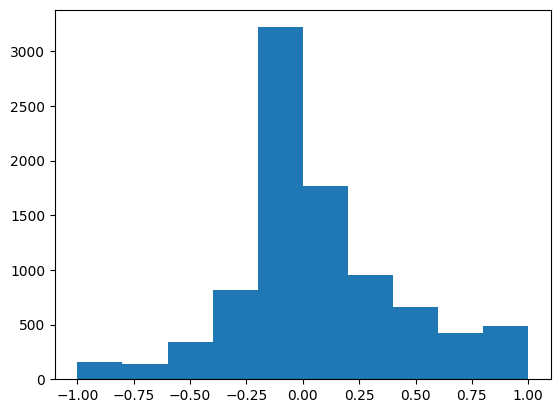

In [14]:
plt.hist(corr_seq)

In [15]:
print(len(corr_seq))
print(np.mean(corr_seq))
print(np.median(corr_seq))
print(ttest_1samp(corr_seq, popmean=0.))

8973
0.06578197951081227
-0.014023207404945365
TtestResult(statistic=16.745261869510696, pvalue=5.325849979366155e-62, df=8972)


# Feature lengths & query type

In [5]:
%%bigquery qt_df
with query_session as (
  select distinct query, query_raw
  from `etsy-data-warehouse-prod.search.query_sessions_new`
  where _date = date('2023-07-03')
),
query_intent as (
  select query_raw,
    case
      when abs(inference.confidence) > 0.8 then inference.label
      else 'uncertain'
    end as intent_label,
    inference.confidence as score
  from `etsy-data-warehouse-prod.arizona.query_intent_labels`
),
query_intent_table as (
  select distinct query, qs.query_raw, intent_label
  from query_session qs
  join query_intent qi
  on qs.query_raw = qi.query_raw
  qualify row_number() over (partition by query order by score desc) = 1
),
fl as (
  select
      query, 
      purchaseLevel2TaxonomyPaths as taxo, 
      purchaseLevel2TaxonomyCounts as cnts,
      purchaseLevel2TaxonomyPrices  as prices,
  from `etsy-search-ml-dev.yzhang.taxo_diversity_raw_train_web_07_03`
)
select fl.*, qit.intent_label
from fl
join query_intent_table qit
on fl.query = qit.query
where array_length(taxo) > 0

Downloading: 100%|████████████| 38511144/38511144 [01:32<00:00, 415769.11rows/s]


In [6]:
qt_df["feature_length"] = qt_df.taxo.apply(len)
qt_df.head()

,query,taxo,cnts,prices,intent_label,feature_length
0,custom portrait,"[art_and_collectibles.prints, art_and_collecti...","[197, 50, 35, 15]","[22.31, 18.85, 21.7, 23.4]",Direct,4
1,bar sign,"[home_and_living.home_decor, weddings.decorati...","[241, 66, 24, 7, 3]","[38.06, 16.96, 10.73, 43.77, 9.14]",Direct,5
2,bar sign,"[home_and_living.home_decor, weddings.decorati...","[241, 66, 24, 7, 3]","[38.06, 16.96, 10.73, 43.77, 9.14]",Direct,5
3,cat earring,[jewelry.earrings],[253],[13.95],Direct,1
4,crochet blanket pattern,"[craft_supplies_and_tools.patterns_and_how_to, ]","[244, 9]","[4.74, 3.83]",Direct,2


<Axes: xlabel='intent_label', ylabel='feature_length'>

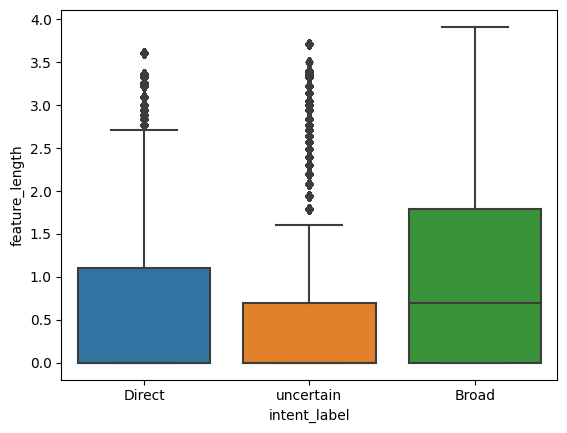

In [9]:
sns.boxplot(x = qt_df.intent_label, y=np.log(qt_df.feature_length))

In [10]:
qt_df.intent_label.value_counts()

intent_label
Direct       20658998
Broad        11058952
uncertain     6793194
Name: count, dtype: int64

In [12]:
feature_length_direct = qt_df[qt_df.intent_label == "Direct"].feature_length.values
feature_length_broad = qt_df[qt_df.intent_label == "Broad"].feature_length.values

In [15]:
ttest_ind(feature_length_direct, feature_length_broad, equal_var=False)

Ttest_indResult(statistic=-1321.0055614459802, pvalue=0.0)

In [16]:
print(np.median(feature_length_direct))
print(np.mean(feature_length_direct))
print(np.median(feature_length_broad))
print(np.mean(feature_length_broad))

1.0
2.2431492079141497
2.0
5.4093466541856765


# Empty strings in taxonomy

```sql
with fl as (
    select
      attributions,
      ctx.docInfo.queryInfo.query, 
      ctx.docInfo.queryInfo.queryTaxoDemandFeatures.*,
    from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_07_16`, 
    unnest(contextualInfo) as ctx
    where ctx.docInfo.queryInfo.query is not null
    and (
        "" in unnest(ctx.docInfo.queryInfo.queryTaxoDemandFeatures.purchaseLevel2TaxonomyPaths)
        -- "" in unnest(ctx.docInfo.queryInfo.queryTaxoDemandFeatures.clickLevel2TaxonomyPaths)
    )
),
query_gms as (
  select query, sum(attributed_gms) as gms
  from `etsy-data-warehouse-prod.search.query_sessions_new`
  where _date = date('2023-07-16')
  group by query
),
output_table as (
  select fl.*, gms
  from fl
  left join query_gms
  on fl.query = query_gms.query
),
tmp as (
  select distinct query, gms
  from output_table
)
select sum(gms) from tmp
```

+ total GMS 93662392
+ queries with empty string in purchase taxos account for 7633958 GMS - 8.2%
+ queries with empty string in click taxos account for 7633958 GMS - 27.0%
+ union of purchase & click: 25728029 GMS - 27.5%

In [78]:
%%bigquery df
select
    attributions,
    ctx.docInfo.queryInfo.query, 
    ctx.docInfo.queryInfo.queryTaxoDemandFeatures.*,
from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_07_16`, 
unnest(contextualInfo) as ctx
where ctx.docInfo.queryInfo.query is not null
and array_length(ctx.docInfo.queryInfo.queryTaxoDemandFeatures.purchaseTopTaxonomyPaths) > 0
# and (
#     "" in unnest(ctx.docInfo.queryInfo.queryTaxoDemandFeatures.purchaseLevel2TaxonomyPaths)
# #     or "" in unnest(ctx.docInfo.queryInfo.queryTaxoDemandFeatures.clickLevel2TaxonomyPaths)
# )
limit 500000

Downloading: 100%|█████████████████| 500000/500000 [00:10<00:00, 47017.02rows/s]


In [79]:
df[df.purchaseLevel2TaxonomyPaths.apply(lambda x: "" in x)][
    [
        "attributions", "query", 
        "purchaseTopTaxonomyPaths", "purchaseTopTaxonomyCounts", 
        "purchaseLevel2TaxonomyPaths", "purchaseLevel2TaxonomyCounts"
    ]
]

,attributions,query,purchaseTopTaxonomyPaths,purchaseTopTaxonomyCounts,purchaseLevel2TaxonomyPaths,purchaseLevel2TaxonomyCounts
58,[no_event],girl backpack,[bags_and_purses],[31],"[bags_and_purses.backpacks, ]","[30, 1]"
59,[no_event],girl backpack,[bags_and_purses],[31],"[bags_and_purses.backpacks, ]","[30, 1]"
60,[no_event],girl backpack,[bags_and_purses],[31],"[bags_and_purses.backpacks, ]","[30, 1]"
102,[no_event],birthday card,[paper_and_party_supplies],[2236],"[paper_and_party_supplies.paper, , art_and_col...","[2231, 6, 6]"
103,[no_event],birthday card,[paper_and_party_supplies],[2236],"[paper_and_party_supplies.paper, , art_and_col...","[2231, 6, 6]"
...,...,...,...,...,...,...
499965,[no_event],vespa,"[accessories, clothing, paper_and_party_suppli...","[11, 8, 3, 3, 1, 1, 1, 1]","[accessories.keychains_and_lanyards, clothing....","[9, 6, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]"
499966,[no_event],vespa,"[accessories, clothing, paper_and_party_suppli...","[11, 8, 3, 3, 1, 1, 1, 1]","[accessories.keychains_and_lanyards, clothing....","[9, 6, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]"
499967,[no_event],vespa,"[accessories, clothing, paper_and_party_suppli...","[11, 8, 3, 3, 1, 1, 1, 1]","[accessories.keychains_and_lanyards, clothing....","[9, 6, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]"
499968,[no_event],vespa,"[accessories, clothing, paper_and_party_suppli...","[11, 8, 3, 3, 1, 1, 1, 1]","[accessories.keychains_and_lanyards, clothing....","[9, 6, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]"


In [80]:
np.sum(df.purchaseTopTaxonomyPaths.apply(lambda x: len(x) == 1 and x[0] == ""))

0

In [72]:
df[df.clickLevel2TaxonomyPaths.apply(lambda x: len(x)==1 and x[0] == "")][
    [
        "attributions", "query", 
        "clickTopTaxonomyPaths", "clickTopTaxonomyCounts", 
        "clickLevel2TaxonomyPaths", "clickLevel2TaxonomyCounts"
    ]
]

,attributions,query,clickTopTaxonomyPaths,clickTopTaxonomyCounts,clickLevel2TaxonomyPaths,clickLevel2TaxonomyCounts


In [73]:
for col_id in range(df.shape[1]):
    print(df.iloc[224, col_id])
    print(df.iloc[225, col_id])

['no_event']
['no_event']
svg windrose
svg windrose
535
535
3
3
1
1
['craft_supplies_and_tools']
['craft_supplies_and_tools']
[535]
[535]
[2.9]
[2.9]
['craft_supplies_and_tools']
['craft_supplies_and_tools']
[3]
[3]
[3.09]
[3.09]
['art_and_collectibles']
['art_and_collectibles']
[1]
[1]
[0.99]
[0.99]
['craft_supplies_and_tools.canvas_and_surfaces'
 'craft_supplies_and_tools.patterns_and_how_to'
 'art_and_collectibles.drawing_and_illustration'
 'art_and_collectibles.prints']
['craft_supplies_and_tools.canvas_and_surfaces'
 'craft_supplies_and_tools.patterns_and_how_to'
 'art_and_collectibles.drawing_and_illustration'
 'art_and_collectibles.prints']
[322 199 186  66]
[322 199 186  66]
[2.78 3.13 2.36 2.44]
[2.78 3.13 2.36 2.44]
['craft_supplies_and_tools.canvas_and_surfaces'
 'art_and_collectibles.prints'
 'art_and_collectibles.drawing_and_illustration']
['craft_supplies_and_tools.canvas_and_surfaces'
 'art_and_collectibles.prints'
 'art_and_collectibles.drawing_and_illustration']
[3 1 1

In [74]:
def l1norm(x):
    if len(x) > 0 and np.sum(x) > 0:
        return x / np.sum(x)
    else:
        return x

In [75]:
df["purchaseLevel2CountsNorm"] = df.purchaseLevel2TaxonomyCounts.apply(l1norm)
df["clickLevel2CountsNorm"] = df.clickLevel2TaxonomyCounts.apply(l1norm)

In [61]:
print(df.purchaseLevel2CountsNorm[0])
print(np.sum(df.purchaseLevel2CountsNorm[0]))

[0.29761905 0.10714286 0.10714286 0.0952381  0.08333333 0.07142857
 0.04761905 0.03571429 0.02380952 0.02380952 0.02380952 0.02380952
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476]
0.9999999999999999


In [62]:
empty_purchase = []
empty_purchase_index = []
empty_click = []
empty_click_index = []

for i in tqdm(range(df.shape[0])):
    # purchase
    p_paths = df.purchaseLevel2TaxonomyPaths[i]
    p_cnts_norm = df.purchaseLevel2CountsNorm[i]
    assert p_paths.shape == p_cnts_norm.shape
    if "" in p_paths:
        p_empty_idx = np.where(p_paths=="")[0][0]
        p_empty_normed_count = p_cnts_norm[p_empty_idx]
        empty_purchase_index.append(p_empty_idx)
        empty_purchase.append(p_empty_normed_count)
        if p_empty_normed_count == 1.0:
            assert len(p_paths) == 1.
        
    # click
    c_paths = df.clickLevel2TaxonomyPaths[i]
    c_cnts_norm = df.clickLevel2CountsNorm[i]
    if "" in c_paths:
        c_empty_idx = np.where(c_paths=="")[0][0]
        c_empty_normed_count = c_cnts_norm[c_empty_idx]
        empty_click_index.append(c_empty_idx)
        empty_click.append(c_empty_normed_count)
        if c_empty_normed_count == 1.0:
            assert len(c_paths) == 1.

100%|████████████████████████████████| 500000/500000 [00:33<00:00, 15056.77it/s]


(array([8.8231e+04, 1.1913e+04, 4.6080e+03, 2.5000e+03, 3.3560e+03,
        2.3800e+02, 3.5400e+02, 2.6000e+02, 8.2000e+01, 3.8080e+03]),
 array([2.13629566e-04, 1.00192267e-01, 2.00170904e-01, 3.00149541e-01,
        4.00128178e-01, 5.00106815e-01, 6.00085452e-01, 7.00064089e-01,
        8.00042726e-01, 9.00021363e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

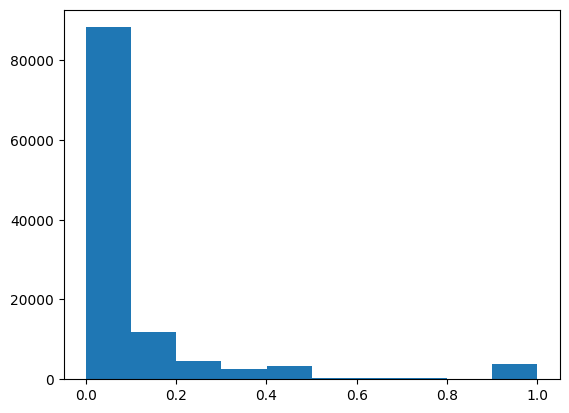

In [63]:
plt.hist(empty_purchase)

In [64]:
print(len(empty_purchase))
print(np.min(empty_purchase))
print(np.max(empty_purchase))
print(np.mean(empty_purchase))
print(np.median(empty_purchase))

115350
0.00021362956633198035
1.0
0.10381215034134701
0.026246719160104987


(array([4.69473e+05, 1.41680e+04, 3.91000e+03, 1.34900e+03, 7.78000e+02,
        2.18000e+02, 3.40000e+01, 1.36000e+02, 0.00000e+00, 5.18000e+02]),
 array([5.11796919e-05, 1.00046062e-01, 2.00040944e-01, 3.00035826e-01,
        4.00030708e-01, 5.00025590e-01, 6.00020472e-01, 7.00015354e-01,
        8.00010236e-01, 9.00005118e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

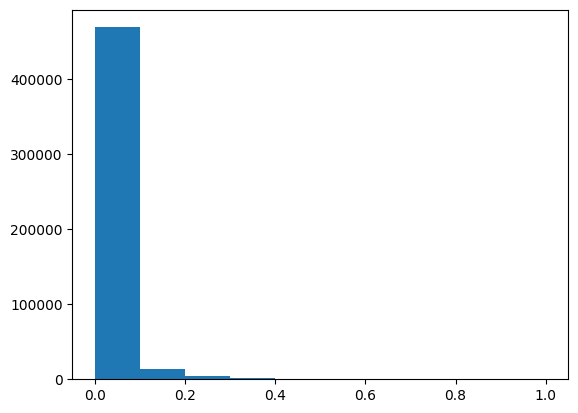

In [65]:
plt.hist(empty_click)

In [66]:
print(len(empty_click))
print(np.min(empty_click))
print(np.max(empty_click))
print(np.mean(empty_click))
print(np.median(empty_click))

490584
5.1179691898254774e-05
1.0
0.02245753644914467
0.007268951194184839


(array([67473., 18227.,  8456.,  7372.,  5120.,  4900.,  2266.,   362.,
         1078.,    96.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <BarContainer object of 10 artists>)

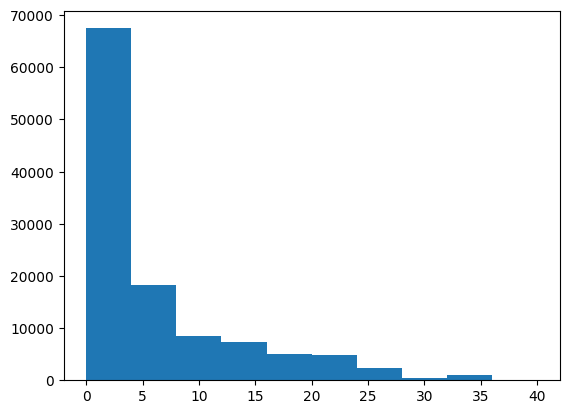

In [69]:
plt.hist(empty_purchase_index)

In [67]:
print(np.min(empty_purchase_index))
print(np.max(empty_purchase_index))
print(np.mean(empty_purchase_index))
print(np.median(empty_purchase_index))

0
40
5.898318162115301
3.0


In [ ]:
plt.hist()

In [68]:
print(np.min(empty_click_index))
print(np.max(empty_click_index))
print(np.mean(empty_click_index))
print(np.median(empty_click_index))

0
49
7.925013861030934
6.0
